# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

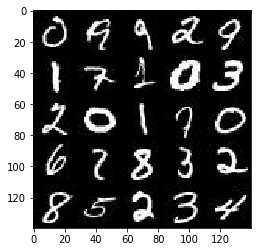

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

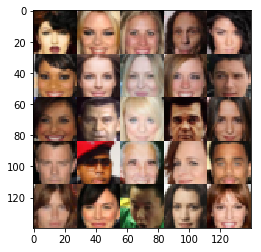

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(dtype=tf.float32, shape=(None, image_width, image_height, image_channels), name="input_real")
    input_z = tf.placeholder(dtype=tf.float32, shape=(None,z_dim), name="input_z")
    learning_rate = tf.placeholder(dtype = tf.float32, name="learning_rate")                            
                             

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/home/carnd/anaconda3/envs/tensorflow-1.1/lib/python3.5/runpy.py", line 184, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/home/carnd/anaconda3/envs/tensorflow-1.1/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/home/carnd/anaconda3/envs/tensorflow-1.1/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>\n    app.launch_new_instance()', 'File "/home/carnd/anaconda3/envs/tensorflow-1.1/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/home/carnd/anaconda3/envs/tensorflow-1.1/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start\n    ioloop.IOLoo

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [16]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    alpha = 0.2
    dropout = 0.25
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input is 28 x 28 x #channels
        # Layer 1, no batch norm on first layer
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha * x1, x1)
        # 14 x 14 x 64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.dropout(x2, rate=dropout, training=True)
        x2 = tf.layers.batch_normalization(x2,training=True)
        relu2 = tf.maximum(alpha * x2, x2)
        # 7 x 7 x 128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.dropout(x3, rate=dropout, training=True)
        x3 = tf.layers.batch_normalization(x3,training=True)
        relu3 = tf.maximum(alpha * x3, x3)
        # 4 x 4 x 256

        flat = tf.reshape(relu3, (-1, 4 * 4 * 256))
        # One output unit
        logits = tf.layers.dense(flat,1, kernel_initializer=tf.contrib.layers.xavier_initializer())
        out = tf.sigmoid(logits)
   
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [17]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
        
    alpha = 0.2
    dropout = 0.25
    with tf.variable_scope('generator', reuse=not is_train):
    
        # Output should be 28 x 28 x out_channels
        x1 = tf.layers.dense(z, 7 * 7 * 512, kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1 = tf.reshape(x1,(-1, 7,7, 512))
        x1 = tf.layers.batch_normalization(x1,training=is_train)
        relu1 = tf.maximum(alpha * x1, x1)
        # 7 x 7 x 512
        
        x2 = tf.layers.conv2d_transpose(relu1, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.dropout(x2, rate=dropout, training=is_train)
        x2 = tf.layers.batch_normalization(x2,training=is_train)
        relu2 = tf.maximum(alpha * x2, x2)
        # 14 x 14 x 256

        x3 = tf.layers.conv2d_transpose(relu2, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.dropout(x3, rate=dropout, training=is_train)
        x3 = tf.layers.batch_normalization(x3,training=is_train)
        relu3 = tf.maximum(alpha * x3, x3)
        # 28 x 28 x 128
         
        # Output
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 3, strides=1, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 28 x 28 x out_channel_dim
        
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [18]:
smooth = 0.1

def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """

    generator_model = generator(input_z, out_channel_dim)
    discriminator_real, discriminator_real_logits = discriminator(input_real)
    discriminator_fake, discriminator_fake_logits = discriminator(generator_model, reuse=True)
  
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_real_logits, labels=tf.ones_like(discriminator_real )*(1 - smooth) ))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_fake_logits, labels=tf.zeros_like(discriminator_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_fake_logits, labels=tf.ones_like(discriminator_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss , g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [19]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`


Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [20]:

class GAN:
    def __init__(self, real_size, z_dim, data_image_mode, beta1=0.5):
                   
        image_width = real_size[1]
        image_height = real_size[2]
        channels = real_size[3]

        self.input_real, self.input_z, self.learning_rate = model_inputs(image_width, image_height,channels, z_dim)

        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z,  channels)
       
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, self.learning_rate, beta1)


def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    
    net = GAN(data_shape, z_dim, data_image_mode)

    steps = 0

    print_every = 10
    show_every = 50
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
   
                steps += 1
                # images are in range -0.5;0.5
                batch_images = batch_images * 2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(net.d_opt, feed_dict={net.input_real: batch_images, net.input_z: batch_z, net.learning_rate: learning_rate})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: batch_images, net.learning_rate: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: batch_images})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    channels = data_shape[3]
                    show_generator_output(sess,25, net.input_z, channels,data_image_mode)
        
        print("Final output")
        channels = get_channels(data_image_mode)
        show_generator_output(sess,25, net.input_z, channels,data_image_mode)


                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.3899... Generator Loss: 4.7345
Epoch 1/2... Discriminator Loss: 0.6724... Generator Loss: 7.1296
Epoch 1/2... Discriminator Loss: 2.4923... Generator Loss: 0.4791
Epoch 1/2... Discriminator Loss: 2.8336... Generator Loss: 0.4881
Epoch 1/2... Discriminator Loss: 1.1570... Generator Loss: 1.1173


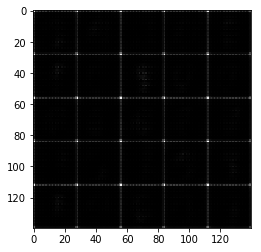

Epoch 1/2... Discriminator Loss: 1.2593... Generator Loss: 2.7230
Epoch 1/2... Discriminator Loss: 1.2211... Generator Loss: 0.9507
Epoch 1/2... Discriminator Loss: 1.0243... Generator Loss: 1.5469
Epoch 1/2... Discriminator Loss: 1.8518... Generator Loss: 3.1534
Epoch 1/2... Discriminator Loss: 1.3544... Generator Loss: 1.4813


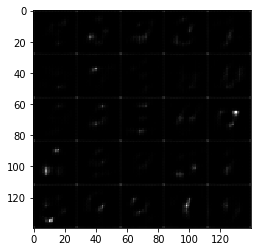

Epoch 1/2... Discriminator Loss: 1.2626... Generator Loss: 2.4612
Epoch 1/2... Discriminator Loss: 1.0852... Generator Loss: 1.2812
Epoch 1/2... Discriminator Loss: 1.4338... Generator Loss: 0.7052
Epoch 1/2... Discriminator Loss: 1.2826... Generator Loss: 0.8930
Epoch 1/2... Discriminator Loss: 1.3567... Generator Loss: 1.0975


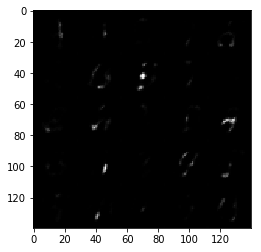

Epoch 1/2... Discriminator Loss: 1.3812... Generator Loss: 1.0415
Epoch 1/2... Discriminator Loss: 1.4598... Generator Loss: 0.6363
Epoch 1/2... Discriminator Loss: 1.1196... Generator Loss: 1.6840
Epoch 1/2... Discriminator Loss: 1.0463... Generator Loss: 1.0685
Epoch 1/2... Discriminator Loss: 1.2088... Generator Loss: 1.3307


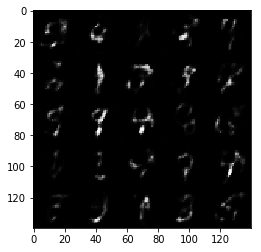

Epoch 1/2... Discriminator Loss: 1.3080... Generator Loss: 0.9424
Epoch 1/2... Discriminator Loss: 1.4471... Generator Loss: 2.2474
Epoch 1/2... Discriminator Loss: 1.2152... Generator Loss: 1.4493
Epoch 1/2... Discriminator Loss: 1.2917... Generator Loss: 0.8282
Epoch 1/2... Discriminator Loss: 1.3115... Generator Loss: 0.9560


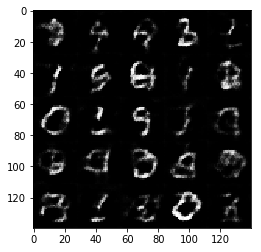

Epoch 1/2... Discriminator Loss: 1.3708... Generator Loss: 0.6742
Epoch 1/2... Discriminator Loss: 1.4587... Generator Loss: 1.8895
Epoch 1/2... Discriminator Loss: 1.2918... Generator Loss: 0.9680
Epoch 1/2... Discriminator Loss: 1.2876... Generator Loss: 1.0592
Epoch 1/2... Discriminator Loss: 1.3351... Generator Loss: 0.8918


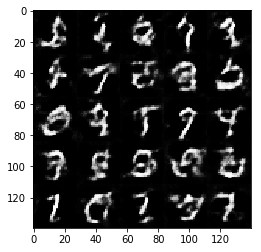

Epoch 1/2... Discriminator Loss: 1.4378... Generator Loss: 0.6394
Epoch 1/2... Discriminator Loss: 1.2380... Generator Loss: 0.9298
Epoch 1/2... Discriminator Loss: 1.3487... Generator Loss: 0.6813
Epoch 1/2... Discriminator Loss: 1.3981... Generator Loss: 0.6740
Epoch 1/2... Discriminator Loss: 1.1185... Generator Loss: 1.1094


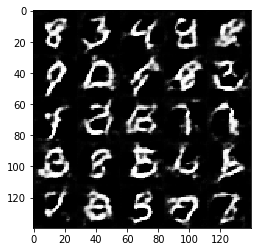

Epoch 1/2... Discriminator Loss: 1.2264... Generator Loss: 0.9956
Epoch 1/2... Discriminator Loss: 1.4720... Generator Loss: 0.8980
Epoch 1/2... Discriminator Loss: 1.2040... Generator Loss: 1.2302
Epoch 1/2... Discriminator Loss: 1.2665... Generator Loss: 1.5649
Epoch 1/2... Discriminator Loss: 1.2454... Generator Loss: 1.0426


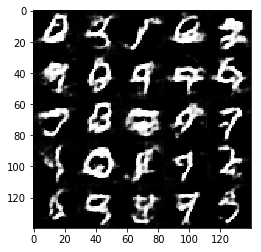

Epoch 1/2... Discriminator Loss: 1.2147... Generator Loss: 1.0952
Epoch 1/2... Discriminator Loss: 1.2396... Generator Loss: 1.0848
Epoch 1/2... Discriminator Loss: 1.3380... Generator Loss: 1.5292
Epoch 1/2... Discriminator Loss: 1.2904... Generator Loss: 0.8649
Epoch 1/2... Discriminator Loss: 1.2835... Generator Loss: 0.8980


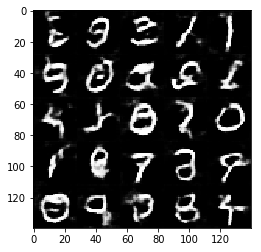

Epoch 1/2... Discriminator Loss: 1.3868... Generator Loss: 1.6478
Epoch 1/2... Discriminator Loss: 1.2579... Generator Loss: 1.0329
Epoch 1/2... Discriminator Loss: 1.3340... Generator Loss: 0.6888
Epoch 1/2... Discriminator Loss: 1.3815... Generator Loss: 0.6483
Epoch 1/2... Discriminator Loss: 1.2016... Generator Loss: 1.0559


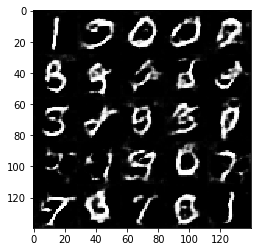

Epoch 1/2... Discriminator Loss: 1.2548... Generator Loss: 1.3347
Epoch 1/2... Discriminator Loss: 1.2508... Generator Loss: 1.3170
Epoch 1/2... Discriminator Loss: 1.1775... Generator Loss: 0.8973
Epoch 1/2... Discriminator Loss: 1.2462... Generator Loss: 1.0105
Epoch 1/2... Discriminator Loss: 1.3622... Generator Loss: 1.7611


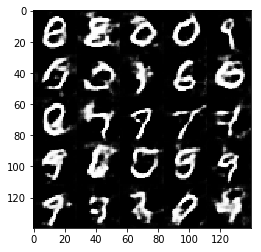

Epoch 1/2... Discriminator Loss: 1.1735... Generator Loss: 1.2133
Epoch 1/2... Discriminator Loss: 1.2995... Generator Loss: 1.2552
Epoch 1/2... Discriminator Loss: 1.2014... Generator Loss: 1.4379
Epoch 1/2... Discriminator Loss: 1.5302... Generator Loss: 0.5349
Epoch 1/2... Discriminator Loss: 1.1209... Generator Loss: 1.0752


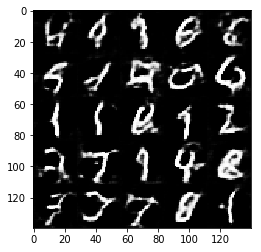

Epoch 1/2... Discriminator Loss: 1.2704... Generator Loss: 0.7815
Epoch 1/2... Discriminator Loss: 1.2610... Generator Loss: 0.7860
Epoch 1/2... Discriminator Loss: 1.3679... Generator Loss: 1.3973
Epoch 1/2... Discriminator Loss: 1.1950... Generator Loss: 0.9324
Epoch 1/2... Discriminator Loss: 1.5948... Generator Loss: 0.4213


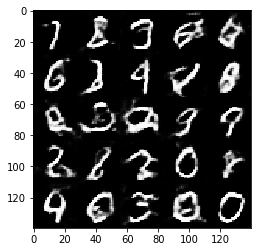

Epoch 1/2... Discriminator Loss: 1.1204... Generator Loss: 1.1141
Epoch 1/2... Discriminator Loss: 1.1415... Generator Loss: 1.2689
Epoch 1/2... Discriminator Loss: 1.4487... Generator Loss: 0.6317
Epoch 1/2... Discriminator Loss: 1.2168... Generator Loss: 1.0938
Epoch 1/2... Discriminator Loss: 1.1844... Generator Loss: 0.8964


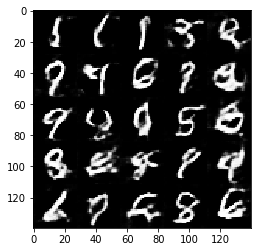

Epoch 1/2... Discriminator Loss: 1.2191... Generator Loss: 1.2025
Epoch 1/2... Discriminator Loss: 1.2577... Generator Loss: 1.1395
Epoch 1/2... Discriminator Loss: 1.2196... Generator Loss: 0.9768
Epoch 1/2... Discriminator Loss: 1.2305... Generator Loss: 0.8274
Epoch 1/2... Discriminator Loss: 1.2100... Generator Loss: 0.7699


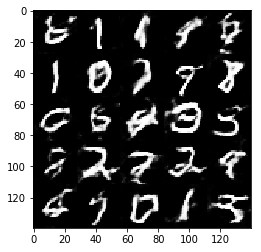

Epoch 1/2... Discriminator Loss: 1.2480... Generator Loss: 0.9972
Epoch 1/2... Discriminator Loss: 1.1435... Generator Loss: 1.2084
Epoch 1/2... Discriminator Loss: 1.6167... Generator Loss: 0.4198
Epoch 1/2... Discriminator Loss: 1.1628... Generator Loss: 1.0707
Epoch 1/2... Discriminator Loss: 1.2415... Generator Loss: 1.3404


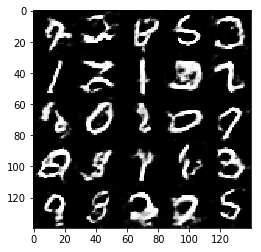

Epoch 1/2... Discriminator Loss: 1.3697... Generator Loss: 0.6300
Epoch 1/2... Discriminator Loss: 1.1551... Generator Loss: 0.9460
Epoch 1/2... Discriminator Loss: 1.0492... Generator Loss: 1.0400
Epoch 1/2... Discriminator Loss: 1.2084... Generator Loss: 1.1917
Epoch 1/2... Discriminator Loss: 1.1840... Generator Loss: 0.7049


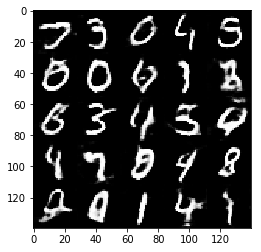

Epoch 1/2... Discriminator Loss: 1.3256... Generator Loss: 0.6160
Epoch 1/2... Discriminator Loss: 1.1687... Generator Loss: 1.1802
Epoch 1/2... Discriminator Loss: 1.1524... Generator Loss: 1.0759
Epoch 1/2... Discriminator Loss: 1.1624... Generator Loss: 1.1744
Epoch 1/2... Discriminator Loss: 1.1698... Generator Loss: 0.9966


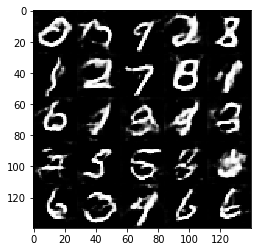

Epoch 1/2... Discriminator Loss: 1.2082... Generator Loss: 1.0118
Epoch 1/2... Discriminator Loss: 1.1466... Generator Loss: 0.9897
Epoch 1/2... Discriminator Loss: 1.1445... Generator Loss: 1.0117
Epoch 2/2... Discriminator Loss: 1.1825... Generator Loss: 1.4950
Epoch 2/2... Discriminator Loss: 1.1608... Generator Loss: 1.1859


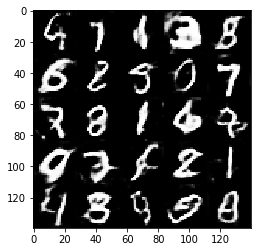

Epoch 2/2... Discriminator Loss: 1.2021... Generator Loss: 1.0752
Epoch 2/2... Discriminator Loss: 1.1228... Generator Loss: 0.8240
Epoch 2/2... Discriminator Loss: 1.2487... Generator Loss: 0.9109
Epoch 2/2... Discriminator Loss: 1.1841... Generator Loss: 0.9995
Epoch 2/2... Discriminator Loss: 1.0747... Generator Loss: 1.1509


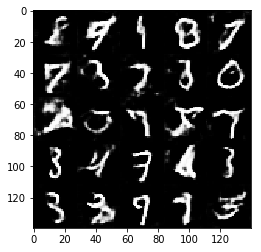

Epoch 2/2... Discriminator Loss: 1.1105... Generator Loss: 1.0750
Epoch 2/2... Discriminator Loss: 1.2849... Generator Loss: 0.5834
Epoch 2/2... Discriminator Loss: 1.1606... Generator Loss: 1.2745
Epoch 2/2... Discriminator Loss: 1.1457... Generator Loss: 1.0778
Epoch 2/2... Discriminator Loss: 1.0861... Generator Loss: 1.1229


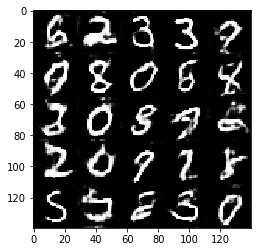

Epoch 2/2... Discriminator Loss: 1.2041... Generator Loss: 0.9724
Epoch 2/2... Discriminator Loss: 1.1205... Generator Loss: 0.8313
Epoch 2/2... Discriminator Loss: 1.1377... Generator Loss: 0.8733
Epoch 2/2... Discriminator Loss: 1.0697... Generator Loss: 0.9762
Epoch 2/2... Discriminator Loss: 1.1072... Generator Loss: 1.0193


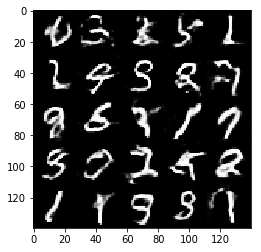

Epoch 2/2... Discriminator Loss: 1.0302... Generator Loss: 1.2336
Epoch 2/2... Discriminator Loss: 1.0612... Generator Loss: 1.0100
Epoch 2/2... Discriminator Loss: 1.1024... Generator Loss: 1.1302
Epoch 2/2... Discriminator Loss: 1.2639... Generator Loss: 1.5196
Epoch 2/2... Discriminator Loss: 1.2466... Generator Loss: 0.6934


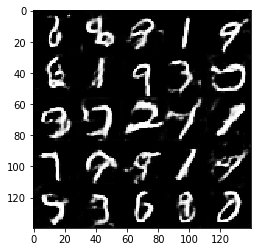

Epoch 2/2... Discriminator Loss: 1.0628... Generator Loss: 1.3210
Epoch 2/2... Discriminator Loss: 1.0983... Generator Loss: 1.1913
Epoch 2/2... Discriminator Loss: 1.1459... Generator Loss: 1.3249
Epoch 2/2... Discriminator Loss: 1.2319... Generator Loss: 1.4467
Epoch 2/2... Discriminator Loss: 1.1924... Generator Loss: 1.1793


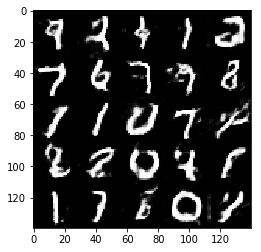

Epoch 2/2... Discriminator Loss: 1.1123... Generator Loss: 0.8352
Epoch 2/2... Discriminator Loss: 1.0803... Generator Loss: 1.5780
Epoch 2/2... Discriminator Loss: 1.1464... Generator Loss: 0.8416
Epoch 2/2... Discriminator Loss: 1.1937... Generator Loss: 0.9617
Epoch 2/2... Discriminator Loss: 1.1706... Generator Loss: 1.0431


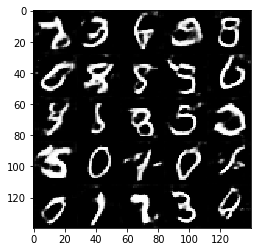

Epoch 2/2... Discriminator Loss: 1.1664... Generator Loss: 0.9180
Epoch 2/2... Discriminator Loss: 1.1245... Generator Loss: 0.8345
Epoch 2/2... Discriminator Loss: 1.0760... Generator Loss: 1.1150
Epoch 2/2... Discriminator Loss: 1.0742... Generator Loss: 1.0170
Epoch 2/2... Discriminator Loss: 1.1745... Generator Loss: 1.4215


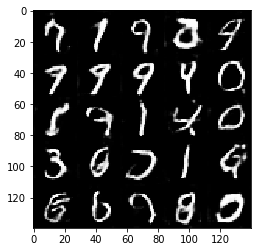

Epoch 2/2... Discriminator Loss: 1.1561... Generator Loss: 0.9191
Epoch 2/2... Discriminator Loss: 1.0477... Generator Loss: 1.1821
Epoch 2/2... Discriminator Loss: 1.2082... Generator Loss: 0.9928
Epoch 2/2... Discriminator Loss: 1.2719... Generator Loss: 1.5061
Epoch 2/2... Discriminator Loss: 1.0960... Generator Loss: 1.1013


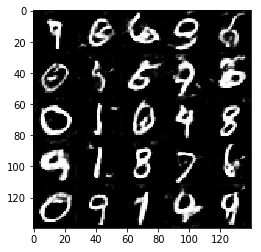

Epoch 2/2... Discriminator Loss: 1.2345... Generator Loss: 0.7084
Epoch 2/2... Discriminator Loss: 1.0125... Generator Loss: 1.1982
Epoch 2/2... Discriminator Loss: 1.0178... Generator Loss: 1.4283
Epoch 2/2... Discriminator Loss: 1.3019... Generator Loss: 0.9822
Epoch 2/2... Discriminator Loss: 1.1389... Generator Loss: 1.5177


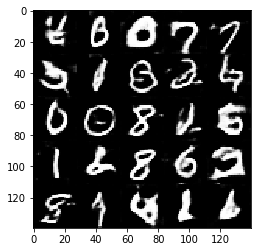

Epoch 2/2... Discriminator Loss: 1.2252... Generator Loss: 0.8216
Epoch 2/2... Discriminator Loss: 1.3605... Generator Loss: 0.5676
Epoch 2/2... Discriminator Loss: 1.3394... Generator Loss: 0.6394
Epoch 2/2... Discriminator Loss: 1.1690... Generator Loss: 1.4035
Epoch 2/2... Discriminator Loss: 1.2689... Generator Loss: 0.8014


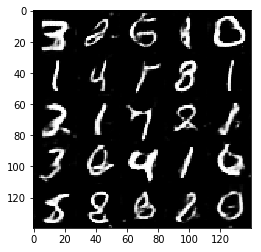

Epoch 2/2... Discriminator Loss: 1.0807... Generator Loss: 1.1903
Epoch 2/2... Discriminator Loss: 1.3490... Generator Loss: 0.6898
Epoch 2/2... Discriminator Loss: 1.3252... Generator Loss: 1.3586
Epoch 2/2... Discriminator Loss: 0.9368... Generator Loss: 1.1568
Epoch 2/2... Discriminator Loss: 1.1413... Generator Loss: 0.8253


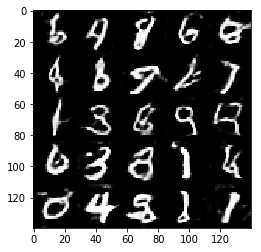

Epoch 2/2... Discriminator Loss: 1.2227... Generator Loss: 0.8905
Epoch 2/2... Discriminator Loss: 1.2614... Generator Loss: 0.6748
Epoch 2/2... Discriminator Loss: 1.0787... Generator Loss: 1.1049
Epoch 2/2... Discriminator Loss: 1.1271... Generator Loss: 1.2040
Epoch 2/2... Discriminator Loss: 1.1967... Generator Loss: 0.8779


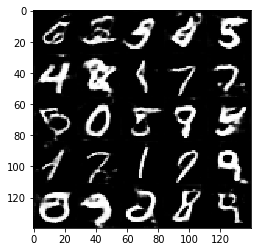

Epoch 2/2... Discriminator Loss: 1.1731... Generator Loss: 0.9631
Epoch 2/2... Discriminator Loss: 1.0486... Generator Loss: 1.1365
Epoch 2/2... Discriminator Loss: 1.0968... Generator Loss: 1.0957
Epoch 2/2... Discriminator Loss: 1.0478... Generator Loss: 1.1725
Epoch 2/2... Discriminator Loss: 1.2268... Generator Loss: 0.8593


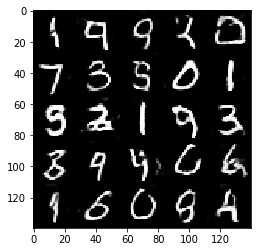

Epoch 2/2... Discriminator Loss: 1.0810... Generator Loss: 0.8353
Epoch 2/2... Discriminator Loss: 1.2484... Generator Loss: 1.8564
Epoch 2/2... Discriminator Loss: 1.0612... Generator Loss: 1.1057
Epoch 2/2... Discriminator Loss: 1.0413... Generator Loss: 1.7333
Epoch 2/2... Discriminator Loss: 1.1762... Generator Loss: 1.0803


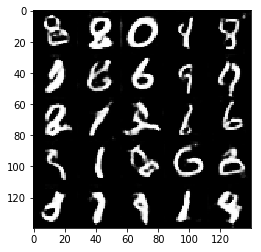

Epoch 2/2... Discriminator Loss: 1.1146... Generator Loss: 1.8604
Epoch 2/2... Discriminator Loss: 1.0361... Generator Loss: 0.8193
Epoch 2/2... Discriminator Loss: 1.3509... Generator Loss: 1.3797
Epoch 2/2... Discriminator Loss: 1.1739... Generator Loss: 1.2167
Epoch 2/2... Discriminator Loss: 0.9819... Generator Loss: 1.2144


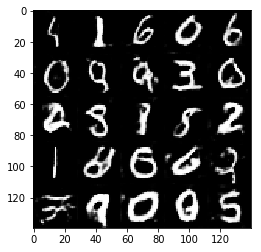

Epoch 2/2... Discriminator Loss: 1.0418... Generator Loss: 0.8429
Epoch 2/2... Discriminator Loss: 1.0634... Generator Loss: 0.8159
Epoch 2/2... Discriminator Loss: 1.1649... Generator Loss: 0.8200
Epoch 2/2... Discriminator Loss: 1.1914... Generator Loss: 1.4770
Epoch 2/2... Discriminator Loss: 0.8608... Generator Loss: 1.2975


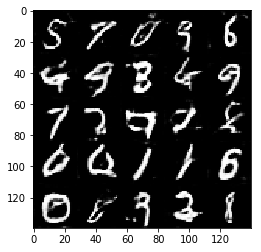

Epoch 2/2... Discriminator Loss: 1.0788... Generator Loss: 1.3137
Epoch 2/2... Discriminator Loss: 1.2598... Generator Loss: 0.7158
Epoch 2/2... Discriminator Loss: 0.9499... Generator Loss: 1.3943
Epoch 2/2... Discriminator Loss: 1.1186... Generator Loss: 0.9913
Epoch 2/2... Discriminator Loss: 1.0291... Generator Loss: 1.3420


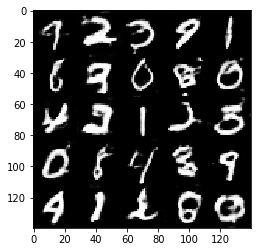

Epoch 2/2... Discriminator Loss: 1.2617... Generator Loss: 0.6879
Epoch 2/2... Discriminator Loss: 1.0351... Generator Loss: 0.9208
Epoch 2/2... Discriminator Loss: 1.0541... Generator Loss: 1.0054
Epoch 2/2... Discriminator Loss: 1.1229... Generator Loss: 1.6632
Epoch 2/2... Discriminator Loss: 0.9945... Generator Loss: 1.4741


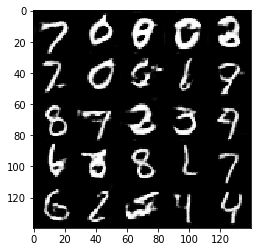

Epoch 2/2... Discriminator Loss: 1.2489... Generator Loss: 1.1618
Epoch 2/2... Discriminator Loss: 1.1263... Generator Loss: 0.9503
Final output


NameError: name 'get_channels' is not defined

In [21]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.4002... Generator Loss: 6.1181
Epoch 1/1... Discriminator Loss: 1.9193... Generator Loss: 10.2023
Epoch 1/1... Discriminator Loss: 2.8209... Generator Loss: 0.2252
Epoch 1/1... Discriminator Loss: 0.9955... Generator Loss: 4.2633
Epoch 1/1... Discriminator Loss: 1.1827... Generator Loss: 0.8530


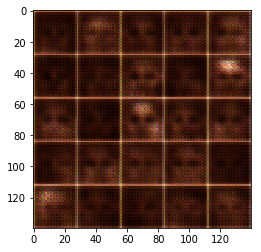

Epoch 1/1... Discriminator Loss: 0.5653... Generator Loss: 2.2606
Epoch 1/1... Discriminator Loss: 0.6883... Generator Loss: 1.6435
Epoch 1/1... Discriminator Loss: 0.5911... Generator Loss: 2.8293
Epoch 1/1... Discriminator Loss: 0.4974... Generator Loss: 4.3491
Epoch 1/1... Discriminator Loss: 0.4219... Generator Loss: 3.8006


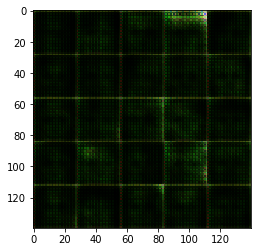

Epoch 1/1... Discriminator Loss: 2.7938... Generator Loss: 0.3191
Epoch 1/1... Discriminator Loss: 1.2619... Generator Loss: 5.2869
Epoch 1/1... Discriminator Loss: 1.1733... Generator Loss: 0.7623
Epoch 1/1... Discriminator Loss: 0.8390... Generator Loss: 1.2904
Epoch 1/1... Discriminator Loss: 0.9026... Generator Loss: 1.3753


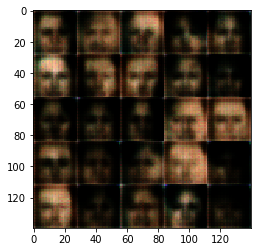

Epoch 1/1... Discriminator Loss: 1.4760... Generator Loss: 1.6504
Epoch 1/1... Discriminator Loss: 0.9530... Generator Loss: 1.6713
Epoch 1/1... Discriminator Loss: 1.3904... Generator Loss: 1.6815
Epoch 1/1... Discriminator Loss: 0.8341... Generator Loss: 1.8734
Epoch 1/1... Discriminator Loss: 1.1742... Generator Loss: 1.2397


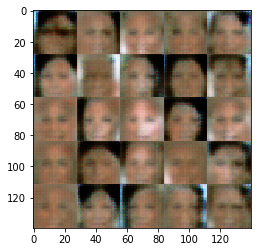

Epoch 1/1... Discriminator Loss: 1.1311... Generator Loss: 0.9109
Epoch 1/1... Discriminator Loss: 0.9306... Generator Loss: 2.1823
Epoch 1/1... Discriminator Loss: 1.3587... Generator Loss: 0.6416
Epoch 1/1... Discriminator Loss: 1.6200... Generator Loss: 0.6161
Epoch 1/1... Discriminator Loss: 0.9771... Generator Loss: 0.8599


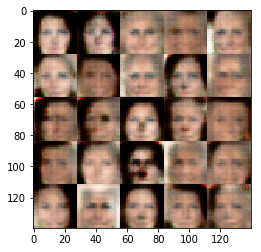

Epoch 1/1... Discriminator Loss: 1.1497... Generator Loss: 0.7590
Epoch 1/1... Discriminator Loss: 1.6430... Generator Loss: 0.4140
Epoch 1/1... Discriminator Loss: 1.1251... Generator Loss: 0.9538
Epoch 1/1... Discriminator Loss: 1.1143... Generator Loss: 0.8969
Epoch 1/1... Discriminator Loss: 1.4318... Generator Loss: 0.5674


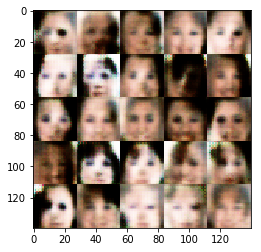

Epoch 1/1... Discriminator Loss: 0.9488... Generator Loss: 1.8588
Epoch 1/1... Discriminator Loss: 1.1295... Generator Loss: 2.3539
Epoch 1/1... Discriminator Loss: 1.2074... Generator Loss: 1.5120
Epoch 1/1... Discriminator Loss: 1.0729... Generator Loss: 1.0036
Epoch 1/1... Discriminator Loss: 1.4683... Generator Loss: 0.6459


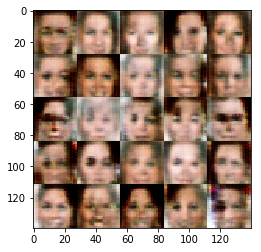

Epoch 1/1... Discriminator Loss: 0.9943... Generator Loss: 1.2912
Epoch 1/1... Discriminator Loss: 1.0895... Generator Loss: 1.0130
Epoch 1/1... Discriminator Loss: 1.1275... Generator Loss: 0.9440
Epoch 1/1... Discriminator Loss: 1.0520... Generator Loss: 1.0969
Epoch 1/1... Discriminator Loss: 1.1215... Generator Loss: 1.2632


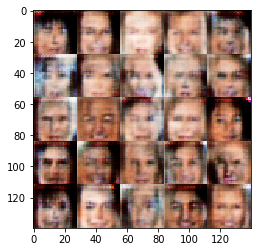

Epoch 1/1... Discriminator Loss: 1.3054... Generator Loss: 0.7886
Epoch 1/1... Discriminator Loss: 1.2740... Generator Loss: 0.7870
Epoch 1/1... Discriminator Loss: 1.1247... Generator Loss: 1.0080
Epoch 1/1... Discriminator Loss: 1.8002... Generator Loss: 2.1596
Epoch 1/1... Discriminator Loss: 1.0295... Generator Loss: 1.0531


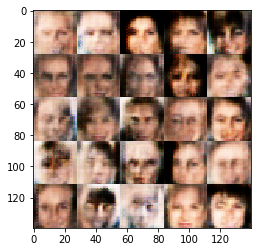

Epoch 1/1... Discriminator Loss: 1.1142... Generator Loss: 0.9143
Epoch 1/1... Discriminator Loss: 1.0279... Generator Loss: 1.3535
Epoch 1/1... Discriminator Loss: 1.2958... Generator Loss: 0.9273
Epoch 1/1... Discriminator Loss: 1.1247... Generator Loss: 1.1492
Epoch 1/1... Discriminator Loss: 1.2028... Generator Loss: 1.0340


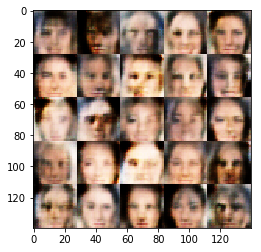

Epoch 1/1... Discriminator Loss: 1.5733... Generator Loss: 0.4792
Epoch 1/1... Discriminator Loss: 1.0515... Generator Loss: 1.1882
Epoch 1/1... Discriminator Loss: 1.1068... Generator Loss: 0.9215
Epoch 1/1... Discriminator Loss: 1.1298... Generator Loss: 1.5003
Epoch 1/1... Discriminator Loss: 1.1927... Generator Loss: 0.7861


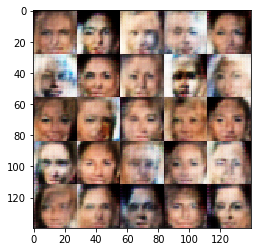

Epoch 1/1... Discriminator Loss: 1.0406... Generator Loss: 1.0117
Epoch 1/1... Discriminator Loss: 1.1047... Generator Loss: 1.0382
Epoch 1/1... Discriminator Loss: 1.1519... Generator Loss: 1.0498
Epoch 1/1... Discriminator Loss: 1.3450... Generator Loss: 0.6081
Epoch 1/1... Discriminator Loss: 1.3268... Generator Loss: 0.7111


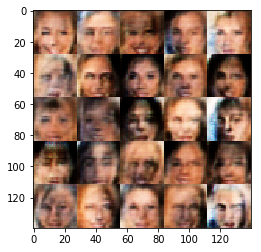

Epoch 1/1... Discriminator Loss: 1.2886... Generator Loss: 0.7896
Epoch 1/1... Discriminator Loss: 1.3256... Generator Loss: 0.7140
Epoch 1/1... Discriminator Loss: 1.6468... Generator Loss: 0.3983
Epoch 1/1... Discriminator Loss: 1.3214... Generator Loss: 1.3717
Epoch 1/1... Discriminator Loss: 1.4986... Generator Loss: 1.3106


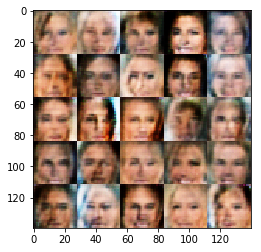

Epoch 1/1... Discriminator Loss: 1.4137... Generator Loss: 0.7023
Epoch 1/1... Discriminator Loss: 1.3797... Generator Loss: 0.9219
Epoch 1/1... Discriminator Loss: 1.4436... Generator Loss: 0.7471
Epoch 1/1... Discriminator Loss: 1.4202... Generator Loss: 1.1784
Epoch 1/1... Discriminator Loss: 1.3055... Generator Loss: 0.7669


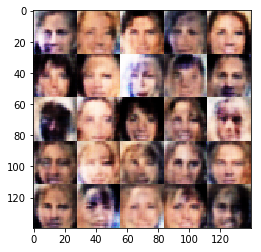

Epoch 1/1... Discriminator Loss: 1.3118... Generator Loss: 0.6888
Epoch 1/1... Discriminator Loss: 1.3071... Generator Loss: 0.6133
Epoch 1/1... Discriminator Loss: 1.6932... Generator Loss: 1.9173
Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.8940
Epoch 1/1... Discriminator Loss: 1.4406... Generator Loss: 1.1341


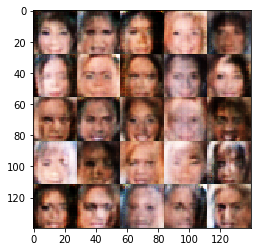

Epoch 1/1... Discriminator Loss: 1.3449... Generator Loss: 0.7668
Epoch 1/1... Discriminator Loss: 1.3194... Generator Loss: 0.8938
Epoch 1/1... Discriminator Loss: 1.3004... Generator Loss: 0.9355
Epoch 1/1... Discriminator Loss: 1.2737... Generator Loss: 0.7242
Epoch 1/1... Discriminator Loss: 1.3179... Generator Loss: 1.0038


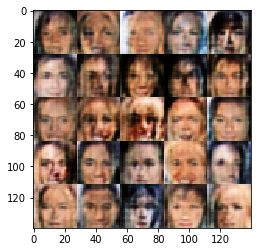

Epoch 1/1... Discriminator Loss: 1.5408... Generator Loss: 0.5582
Epoch 1/1... Discriminator Loss: 1.2337... Generator Loss: 0.8834
Epoch 1/1... Discriminator Loss: 1.5729... Generator Loss: 0.7406
Epoch 1/1... Discriminator Loss: 1.2346... Generator Loss: 0.9243
Epoch 1/1... Discriminator Loss: 1.4300... Generator Loss: 0.7177


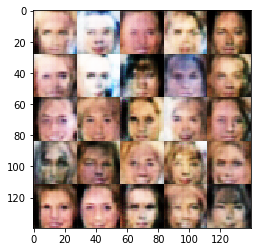

Epoch 1/1... Discriminator Loss: 1.3356... Generator Loss: 0.7849
Epoch 1/1... Discriminator Loss: 1.3338... Generator Loss: 0.8360
Epoch 1/1... Discriminator Loss: 1.2294... Generator Loss: 0.7733
Epoch 1/1... Discriminator Loss: 1.5046... Generator Loss: 0.6511
Epoch 1/1... Discriminator Loss: 1.3677... Generator Loss: 0.7053


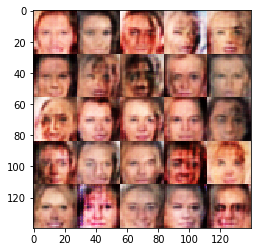

Epoch 1/1... Discriminator Loss: 1.3715... Generator Loss: 0.7753
Epoch 1/1... Discriminator Loss: 1.3874... Generator Loss: 0.9606
Epoch 1/1... Discriminator Loss: 1.5842... Generator Loss: 0.4820
Epoch 1/1... Discriminator Loss: 1.4939... Generator Loss: 0.8203
Epoch 1/1... Discriminator Loss: 1.3798... Generator Loss: 0.7517


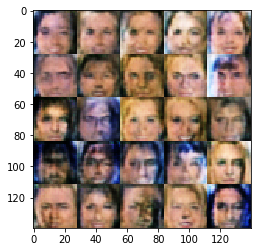

Epoch 1/1... Discriminator Loss: 1.4031... Generator Loss: 0.8387
Epoch 1/1... Discriminator Loss: 1.4320... Generator Loss: 0.9784
Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 0.7960
Epoch 1/1... Discriminator Loss: 1.5148... Generator Loss: 0.7390
Epoch 1/1... Discriminator Loss: 1.4906... Generator Loss: 0.6691


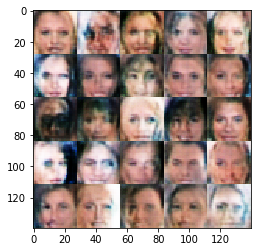

KeyboardInterrupt: 

In [23]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.